<a href="https://colab.research.google.com/github/jonhyuk0922/Tensorflow-Dev/blob/main/Course2_1_Exploring_Larger_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##1. Import Libraries

In [2]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

##2. Data load

In [3]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2021-05-14 14:50:35--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.72.156.109, 2600:1408:9000:89d::e59, 2600:1408:9000:887::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.72.156.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   212MB/s    in 3.7s    

2021-05-14 14:50:39 (214 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [4]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/'))) #각각 12,501장씩있다.

12501
12501


In [6]:
#디렉토리 생성
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

##3. Data validation
source data에서 데이터 분할 후 각 디렉토리 별 저장하는 함수 생성

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring")
  
  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files,len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

In [8]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"

TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"

DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

In [9]:
split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [10]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))
# 각각 12,500장 이다. 한장씩 제외되서!

11250
11250
1250
1250


##4. Define a Model

In [11]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512,activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                    ])

##5. Compile a Model

In [12]:
model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

## 6. ImageDataGenerator

In [13]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode = 'binary',
                                                    target_size=(150,150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1/255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150,150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## 7. Model Fitting

In [14]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
156/225 [===================>..........] - ETA: 19s - loss: 0.7797 - accuracy: 0.5900

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 105s 319ms/step - loss: 0.7371 - accuracy: 0.6093 - val_loss: 0.5153 - val_accuracy: 0.7424
Epoch 2/15
225/225 [==============================] - 70s 312ms/step - loss: 0.5136 - accuracy: 0.7440 - val_loss: 0.4623 - val_accuracy: 0.7880
Epoch 3/15
225/225 [==============================] - 70s 312ms/step - loss: 0.4367 - accuracy: 0.7962 - val_loss: 0.4407 - val_accuracy: 0.7900
Epoch 4/15
225/225 [==============================] - 71s 314ms/step - loss: 0.3832 - accuracy: 0.8295 - val_loss: 0.4216 - val_accuracy: 0.8064
Epoch 5/15
225/225 [==============================] - 71s 314ms/step - loss: 0.3195 - accuracy: 0.8624 - val_loss: 0.3991 - val_accuracy: 0.8176
Epoch 6/15
225/225 [==============================] - 70s 313ms/step - loss: 0.2522 - accuracy: 0.8969 - val_loss: 0.5987 - val_accuracy: 0.7724
Epoch 7/15
225/225 [==============================] - 70s 310ms/step - loss: 0.1957 - accuracy: 0.9210 - val_loss: 0.4440 - val_accuracy: 0.

## 8. Visualization

<Figure size 432x288 with 0 Axes>

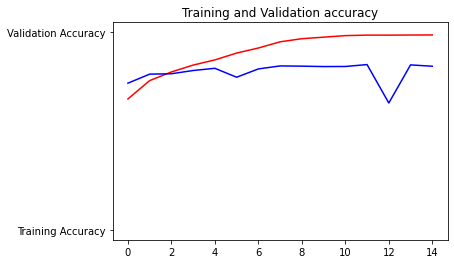

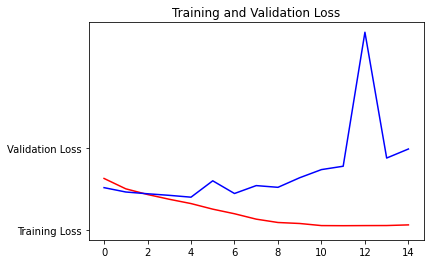

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#plot train and validation acc per epoch
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.figure()

#plot train and validation loss per epoch
plt.plot(epochs, loss, 'r','Training Loss')
plt.plot(epochs, val_loss, 'b','Validation Loss')
plt.title('Training and Validation Loss')
plt.figure()

## 9. Create a Image Classifier

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

#사진 업로드
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x =image.img_to_array(img)
  x = np.expand_dims(x,axis=0)

  images = np.vstack([x])
  classes = model.predict(images,batch_size=10)
  print(classes[0])
  if classes[0] >0.5:
    print(fn + "is a dog")
  else:
    print(fn + "is a cat")

Saving 다운로드 (2).jpeg to 다운로드 (2).jpeg
[0.]
다운로드 (2).jpegis a cat
